# 004: Grain Mapping
### Map grains by identifying cluster of pixels in orientation space
Local indexing returns orientation and unit cell on each pixel of the map, but no grains are defined at this stage. We propose here a rough grain mapping method inspired from Johnstone et al. (2020) (https://arxiv.org/abs/2001.02716), using density-based clustering (DBSCAN). 

The distance metrics combines symmetry-reduced orientations and ($x$,$y$) position of pixels in the sample, to take into account both position and orientation of pixels. This should avoid grouping together pixels from grains located in different parts of the sample but showing similar orientations. However, if you think clustering only by orientation is better, it is possible to adapt this method to use only orientations.

***
WARNING: This is a very rough approach, which works as long as the orientation clusters formed by the different grains are well separated. There is no guarantee that groups of pixels identified this way correspond to topologically valid grains: a single cluster can correspond to disconnected groups of pixels / voxels. For more robust grain mapping, there are several methods implemented in MTex which rely on identification of grain boundaries. 

### load packages

In [1]:
# general modules
import os, sys
import numpy as np
import pylab as pl
from tqdm import tqdm

# ImageD11 + point-fit 3dxrd module
import ImageD11.grain
import ImageD11.columnfile
import ImageD11.sinograms.dataset

if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
from pf_3dxrd import utils, pixelmap, friedel_pairs, crystal_structure, peak_mapping

# orix
from orix import quaternion as oq, vector as ovec

# clustering
from sklearn.cluster import DBSCAN
import sklearn.metrics
from scipy.spatial import KDTree


%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Load data

This notebook has been written to process a z-stack of 2D maps (to map grains in 3D). However, it works as well if you just have one 2D map. Just put one item in dslist below. Put the name of phases to index in phase_name_list. If multiple phases were indexed, the grainmapping procedure will be run independantly for each phase. Then, a grain map will be generated in such a way that grain index do not overlap between different phases. 

In [ ]:
# paths
data_dir = 'data'
parfile='data/SI3.par'
sample = 'SI3'

dslist = ['SI3_DT360Z5480','SI3_DT360Z5480']   # list of datasets to load
phase_name_list = ['quartz', 'orthoclase']  # list of phases to map


In [20]:
def load_xmap(dsname):
    xmap_file = os.path.join(data_dir, dsname+'_xmap.h5')
    xmap = pixelmap.load_from_hdf5(xmap_file)
    #print(xmap)
    
    return xmap

def load_cf(dset, phase):
    peakfile = os.path.join(data_dir, f'{dsname}_pks_p_flt.h5')
    dsfile = os.path.join(data_dir, f'{dsname}_dataset.h5')
    
    ds = ImageD11.sinograms.dataset.load(dsfile)
    
    cf = ImageD11.columnfile.columnfile(peakfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)
    cf.sortby('xyi')
        
    return cf 

Create a dictionnary containing all 2D maps from the stack. 

Several columns 'features_[phase], 'mask_[phase] and 'ori_[phase]' have been initialized.

In [21]:
%%time
# dictionnary keys
###################
# dset: dataset name
# xmap: pixelmap
# features_[phasename]: normalized 4D space to perform clustering
# mask_[phasename]: mask to select pixels corresponding to the given phase on the map. 

keys = ['dset', 'xmap'] + [f'features_{p}' for p in phase_name_list] +\
                          [f'mask_{p}' for p in phase_name_list]     +\
                          [f'ori_{p}' for p in phase_name_list]

data = [[] for _ in range(len(keys))]
DATA_dict = dict(zip(keys,data))        
    
# load xmaps

for dsname in dslist:
    xmap = load_xmap(dsname)
    xmap.add_data(np.full(xmap.xyi.shape, -1, dtype=np.int16), 'grain_id')
    DATA_dict['dset'].append(dsname)
    DATA_dict['xmap'].append(xmap)

del data  
DATA_dict

CPU times: user 939 ms, sys: 1.98 s, total: 2.92 s
Wall time: 688 ms


{'dset': ['SI3_DT360Z5480', 'SI3_DT360Z5480'],
 'xmap': [<pf_3dxrd.pixelmap.Pixelmap at 0x7fbf7bd9cb80>,
 'features_quartz': [],
 'features_orthoclase': [],
 'mask_quartz': [],
 'mask_orthoclase': [],
 'ori_quartz': [],
 'ori_orthoclase': []}

For each phase, we need to define a space of features in which clustering will be performed. This space needs to be normalized somehow, so that variation in orientation and (xi,yi) coordinate vary over similar ranges within a cluster. This is done with the function below. pixel orientation and coordinates in feature space are then added to DATA_dict for each phase. 

In [22]:
def get_normalized_feature_space(xmap, pname):
    """ select orientation from xmap and return normalized feature space built using symetry-reduced orientations 
    (in euler angles) and (x,y) position: (eul1, eul2, xi, yi). Each dimension is rescaled to values between 0 and 1
    
    return:
    features: 4D array of values to perform clustering
    cs: corresponding crystal phase
    mask : phase mask for pixels in xmap
    """
    # phase structure, mask and symmetry
    cs = xmap.phases.get(pname)
    msk = xmap.phase_id == cs.phase_id
    sym = cs.orix_phase.point_group.laue
    # orientation in symmetry reduced zone
    ori_quat = oq.Orientation.from_matrix(xmap.U[msk], symmetry = sym)
    ori_quat = ori_quat.map_into_symmetry_reduced_zone()
    ori_euler = ori_quat.to_euler(degrees=True)
    xi, yi = xmap.xi[msk], xmap.yi[msk]
    
    # normalize
    d1 = ori_euler[:,0] / 360
    d2 = ori_euler[:,1] / 90
    d3 = (xi - xi.min()) / (xi.max() - xi.min())
    d4 = (yi - yi.min()) / (yi.max() - yi.min())
    
    return ori_quat, np.array([d1,d2,d3,d4]).T, cs, msk

def update_dict(pname):
    # compute feature space for each map and update dictionnary
    for xmap in DATA_dict['xmap']:
        ori, features, cs, msk = get_normalized_feature_space(xmap, pname)
        DATA_dict[f'mask_{pname}'].append(msk)
        DATA_dict[f'features_{pname}'].append(features)
        DATA_dict[f'ori_{pname}'].append(ori)


for pname in phase_name_list:
    update_dict(pname)

# print updated dictionnary to check it is ok
# xmap size and mask_phase should have the same shape
# feature_phase shape should be (N,4) with N <= xmap size

for i, dset in enumerate(DATA_dict['dset']):
    print(f'Dataset {dset}\n-----------------------')
    for k,v in DATA_dict.items():
        if 'xmap' in k:
            print(f'{k} size: {v[i].xyi.shape}')
        if any(['features' in k, 'mask' in k]):
            print(f'{k}:{v[i].shape}')
            
    print('=========================')
        
        

Dataset SI3_DT360Z5480
-----------------------
xmap size: (12100,)
features_quartz:(1537, 4)
features_orthoclase:(918, 4)
mask_quartz:(12100,)
mask_orthoclase:(12100,)
Dataset SI3_DT360Z5480
-----------------------
xmap size: (12100,)
features_quartz:(1537, 4)
features_orthoclase:(918, 4)
mask_quartz:(12100,)
mask_orthoclase:(12100,)


Concatenate all arrays of features into one big array for each phase. This will allow to do clustering in 3D instead of doing it slice by slice (ie. directly identify grains in 3D)

In [23]:
stacked_features = {pname:_ for pname in phase_name_list}

for pname in phase_name_list:
    stacked_features[pname] = np.concatenate([ft for ft in DATA_dict[f'features_{pname}']])
    print(f'All datasets - {pname}: {stacked_features[pname].shape}')

All datasets - quartz: (3074, 4)
All datasets - orthoclase: (1836, 4)


### DBSCAN Clustering

Now that each pixel has been assigned coordinates in a feature space, we can run DBSCAN clustering. 

#### Parameters for DBSCAN: eps and min_samples
DBSCAN has two parameters to adjust: eps and min_sample

- eps controls the maximum distance between two points for one to be considered as in the neighborhood of the other. This is the most important parameter.
- min_samples controls the number of points in a neighborhood for a point to be considered as a core point. Higher values will identify denser clusters, while lower values will identify more sparse clusters.

#### cluster using a subset
For large maps, the number of pixels to cluster can be very big (>1M), resulting in long computation time and large memory consumption for DBSCAN clustering. To avoid this, it is possible to take a subset of pixels, and map each pixel in the full set to its closests neighbour in the subset (in feature space). Then, clustering is done on the subset, and cluster labels found in the subset are mapped to the full set of pixels. 

To use this method, set use_subset = True in the function fit_dbscan below. Downsampling_factor is an integer controling the size of the subset. If downsampling_factor = n, len(data_subset) ~ len(data) / n

For dataset SI3_DT360Z5480, using a subset is not recommended, since the size of the map is already pretty small and taking a smaller subset would result in poor clustering performance. 


In [27]:
# function for clustering

def fit_dbscan(data, eps=0.5, min_samples=5, use_subset=False, downsampling_factor = 2):
    # define model
    model = DBSCAN(eps = eps, min_samples = min_samples)
    
    # select data to cluster: either full data or a subset
    if use_subset:
        data_to_fit = data[::downsampling_factor]
    else: 
        data_to_fit = data
    
    # cluster data
    labels = model.fit_predict(data_to_fit)
    clst, clst_size = np.unique(labels, return_counts=True)
    
    # cluster centroids (for labels != -1, which corresponds to data not assigne dot any cluster
    clst_cs = []
    for i in clst:
        if i == -1:
            continue
        cen = np.median(data_to_fit[labels == i], axis=0)
        clst_cs.append(cen)
    clst_cs = np.array(clst_cs)
    
    # Map full data to nearest subset points (if subset is used)
    if use_subset:
        kd_tree = KDTree(data_to_fit)
        _, nearest_indices = kd_tree.query(data, k=1)
        labels_all = labels[nearest_indices.flatten()]
    else:
        labels_all = labels
    
    return labels_all, clst, clst_size, clst_cs



def performance_metrics(data, labels):
    """ Evaluate the clustering performance using various criteria"""
    ncl = len(np.unique(labels)) - 1
    
    # completeness : prportion of points assigned to a cluster
    completeness = np.count_nonzero(labels != -1)/len(labels) 
    
    #  Mean Silhouette Coeff. Calculated using the mean intra-cluster distance and the mean nearest-cluster distance
    # ranges from 1 (best) to -1 (worst). ~0 : overlapping clusters. <0 : probably wrong cluster assignment
    silhouette = sklearn.metrics.silhouette_score(data, labels, sample_size=10000)
    
    # Davies-Bouldin score: average similarity measure of each cluster with its most similar cluster
    #clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero,
    # with lower values indicating better clustering.
    dbi = sklearn.metrics.davies_bouldin_score(data, labels)
    
    # Variance Ratio Criterion (Calinski and Harabasz score): ratio of the sum of between-cluster dispersion and of
    # within-cluster dispersion. Higher value indicate better clustering, because it means that the data points are
    # more spread out between clusters than they are within clusters. 
    vrc = sklearn.metrics.calinski_harabasz_score(data, labels)
    
    titles = 'N clusters,Completeness,Mean Silhouette Coeff,Davies-Bouldin Score,Variance Ratio Criterion'.split(',')
    stats = [ncl, completeness, silhouette, dbi, vrc]
    performance_stats = {t:arr for t,arr in zip(titles,stats)}
    
    return performance_stats


#### Adjust DBSCAN parameters 

In order to find the best values eps and min_sample, we can try to vary these values and evaluate clustering performance for each value. A series of metrics are then defined in sklearn to evaluate the quality of clustering. Read comments in performance_metrics above, or find the documentation of these functions in sklearn.metrics for more details. 

Let's try first with quartz, varying eps. 

In [50]:
# try different values of eps and min_sample in DBSCAN and evaluate performance.
# For SI3_DT360Z5480, downsampling is not needed sinc ethe map is pretty small.

phase = 'orthoclase'

# define array of eps. Use a wide range first, to see how the performance metrics behave 
eps = np.linspace(0.05,0.3,30)
min_samples = 5

titles = 'N clusters,Completeness,Mean Silhouette Coeff,Davies-Bouldin Score,Variance Ratio Criterion'.split(',')
stats_all = {t:[] for t in titles}


for e in tqdm(eps):
    # find clusters for data subset
    data = stacked_features[phase]
    labels, clst, clst_size, clst_cs = fit_dbscan(data, e, min_samples, use_subset=False)

    # compute performance stats
    try:
        stats = performance_metrics(data, labels)
        for s_all,s_i in zip(stats_all.values(), stats.values()):
            s_all.append(s_i)
        
    except:
        for s_all in stats_all.values():
            s_all.append(np.nan)

vcr = 'Variance Ratio Criterion'
stats_all[vcr] = np.array(stats_all[vcr]) / np.nanmax(stats_all[vcr])

100%|██████████| 30/30 [00:01<00:00, 19.15it/s]


For each eps value, performance metrics are computed and stored in stats_all dict. Now we can plot performance metrics vs eps. and  vs. N_clusters

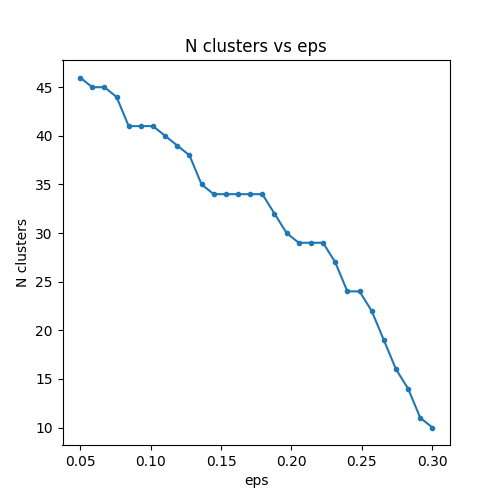

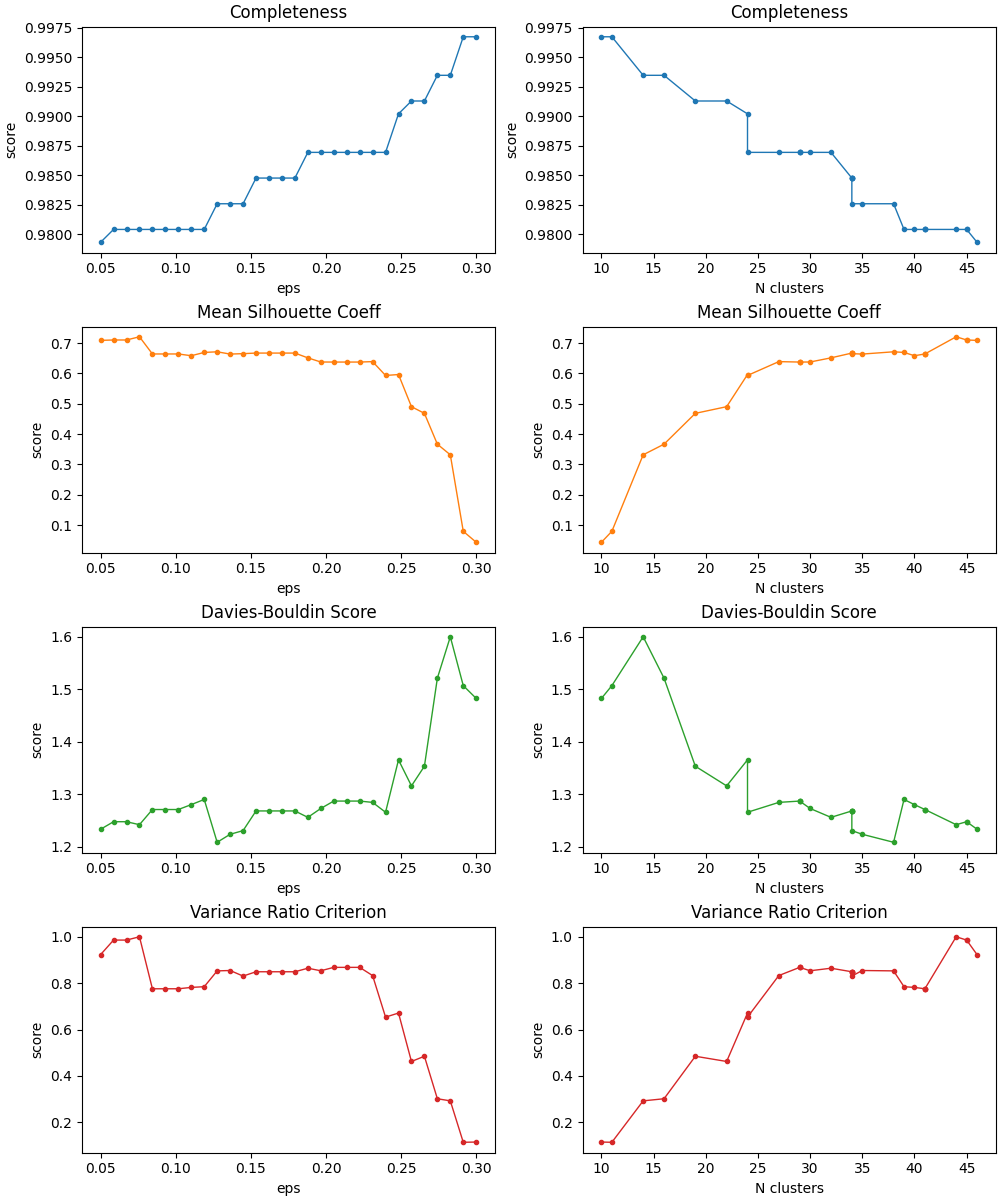

In [51]:
# plot performance index
nrow = len(stats_all) - 1
colors = pl.matplotlib.cm.tab10.colors


pl.figure(figsize=(5,5))
pl.plot(eps, stats_all['N clusters'], '.-')
pl.xlabel('eps')
pl.ylabel('N clusters')
pl.title('N clusters vs eps')

fig, ax = pl.subplots(nrow,2, figsize=(10,3*nrow), layout='constrained')

for i, (t,v) in enumerate(stats_all.items()):
    i = i-1
    if t == 'N clusters':
        continue
    color= colors[i]
    ax[i,0].plot(eps, v, '.-', lw=1., color = color)
    ax[i,0].set_xlabel('eps')
    ax[i,0].set_ylabel('score')
    ax[i,0].set_title(t)
    
    ax[i,1].plot(stats_all['N clusters'], v, '.-', lw=1., color=color)
    ax[i,1].set_xlabel('N clusters')
    ax[i,1].set_ylabel('score')
    ax[i,1].set_title(t)
    
    

#### N_clusters vs. eps

The number of clusters found broadly decreases with increasing eps. This is expected, since eps controls the maximum distance between points in a neighborhood. Larger eps thus returns larger clusters with larger distance between points, while lower eps will identify smaller, more closely grouped clusters. 

#### performace metrics vs. eps / N_cluster
Optimal eps should correspond to highest completeness, variance ratio criterion, silhouette coefficient, and lowest davies-bouldin score. For quartz in SI3_DT360Z5480, there is a significant drop of these statistics below eps = 0.05 (N_cluster > 38) and above eps = 0.2 (N_clusters < 30). The number of optimal clusters seems to be around 35, for eps ~ 0.15. 


The same procedure need sot be done separately for each phase,because optimal clustering parameters are not necessarilty the same. 
If possible, it is generally a good practice to compare the optimal number of clusters found using these metrics with the number you would expect by looking at ipf orientation maps (plotted in the previous tutorial).

### Find grains
Once optimal clustering parameters have been adjusted for all phases, perform DBSCAN clustering. Outputs are stored in two dictionnaries: grain_labels dict contains cluster labels (grain index) for each pixel, and clusters dict contains label, centroid and size of each cluster.

In [88]:
# clustering params for each phase in stacked_features
eps_list = [0.15, 0.08]
min_samples_list = [10, 5]

# initialize dict of results
grain_labels = {p:[] for p in stacked_features}
clusters     = {p:[] for p in stacked_features}

# Clustering: return a grain label for each data point, first in data subset and then in full data
for p,eps,ms in zip(stacked_features, eps_list, min_samples_list):
    
    # find clusters in data subset with dbscan
    labels, clst_ids, clst_size, clst_cs = fit_dbscan(stacked_features[p], eps, ms, use_subset=False)
    
    grain_labels[p] = labels
    clusters[p] = [clst_ids, clst_size, clst_cs]
    print(f'{p} pixels clustering completed. Found {len(clst_ids)-1} unique grains.')
    
    
# We do not want grains from different phases to have the same grain label. Thus we need to update the results so that each phase has its 
# unique set of grain labels
print('===================================')
print('unique grain labels\n----------------------------')
for i, (p, labs) in enumerate(grain_labels.items()):
    
    clst_labs = clusters[p][0]
    
    # for the first phase in grain labels dict, do not change anything
    if i == 0:
        labels_unique = np.unique(labs)
    # for other phases, update labels whenever they are > -1 (-1 stands for non-labeled outliers)
    else:
        labs = np.where(labs == -1, -1, labs + max(labels_unique) + 1)
        clst_labs = np.where(clst_labs == -1, -1, clst_labs + max(labels_unique) + 1)
        labels_unique = np.concatenate((labels_unique,np.unique(labs)))
        grain_labels[p] = labs
        clusters[p][0] = clst_labs
        
        
    # print outputs
    print(f'{p}:\n{np.unique(labs)}\n-----------------------')
    

quartz pixels clustering completed. Found 36 unique grains.
orthoclase pixels clustering completed. Found 43 unique grains.
unique grain labels
----------------------------
quartz:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35]
-----------------------
orthoclase:
[-1 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78]
-----------------------


### Plots
Make some plots to check grain identification is ok:
- pixels colored by cluster id in symmetry-reduced orientation space
- scatter plot of cluster centroids over ipf color map for each phase. Dot color (within the white circle) is determined from the mean orientation of the cluster, using the same color key as the ipf map. Therefore, the color of each dot should be the same as the color of the corresponding grain. 


Check that:
- all points within a cluster have the same color (fig1)
- there are no black clusters (unlabeled points). You can also check the completeness index in performance_stats, which measures the proportion of labeled points over the total numnber of points. 
- grain centroids plot in the center of grains (fig.2) and have the same ipf color (ie similar orientation). 

In [89]:
# define colormap for clusters
Ncolors = labels_unique.max() + 1
cmap = utils.random_color_map(Ncolors)

In [92]:
# plotting functions

def get_subset_orientations(pname):
    """ return all orientations for the data subset, mapped into the symmetry_reduced zone, for phase pname"""
    # select data
    cs = xmap.phases.get(pname)
    ori_arr = np.concatenate([o.data for o in DATA_dict[f'ori_{pname}']])  # stacked orientations from all maps
    ori_stacked = oq.Orientation(ori_arr, symmetry=cs.orix_phase.point_group.laue)
    ori_stacked.map_into_symmetry_reduced_zone()
    
    return ori_stacked


def get_cluster_orientations(pname):
    """ 
    return mean orientation for all clusters mapped into the symmetry-reduced zone, for phase pname
    """
    cs = xmap.phases.get(pname)
    ori = get_subset_orientations(pname)  # pixel orientation
    
    clst_ids, clst_size, clst_cs = clusters[pname]  # cluster properties: id, size, centroid
    labels = grain_labels[pname]                    # pixel labels in data subset
                          
    # mean cluster orientation
    q_mean = [ori[labels == l].mean() for l in  clst_ids[1:]]
    ori_clusters = oq.Orientation.stack(q_mean).flatten()
    ori_clusters.symmetry = ori.symmetry
    ori_clusters.map_into_symmetry_reduced_zone()
    
    return ori_clusters



def make_ipf_plots(pname, ipf_direction = [0,0,1], save=False):
    """ 
    plot pixel orientation in inverse pole figure space 
    + make scatter plot of cluster centroids overlapped with ipf color map from xmap
    
    pname : phase name 
    cluster_size_factor: adjust spot size for clusters in scatter plot
    ipf_direction: reference direction ofr the inverse pole figure. z-axis = [0,0,1] (default)
    save (bool): save plot
    """
    # extract data
    cs = xmap.phases.get(pname)
    cs.get_ipfkey()
    labels = grain_labels[pname]
    clst_ids, clst_size, clst_cs = clusters[pname]

    # pixel orientations
    ori = get_subset_orientations(pname)
    
    # cluster orientations
    clst_ori = get_cluster_orientations(pname)
    clst_rgb = cs.ipfkey.orientation2color(clst_ori)  # color for plotting
    
    # IPF reference orientation + arguments for plotting
    oref = ovec.Vector3d(ipf_direction)
    kw_subplot = {'projection':'ipf', 'symmetry':cs.orix_phase.point_group.laue, 'direction':oref}
    kw_density = {'cmap':'Reds', 'log':True, 'resolution':.5, 'sigma':.5}

    # fig1 : symmetry-reduced ipf space
    fig1 = pl.figure(figsize=(10,5))
    ax1 = fig1.add_subplot(121, **kw_subplot)
    ax2 = fig1.add_subplot(122, **kw_subplot)

    ax1.scatter(ori, s=2., c = labels, cmap = cmap, vmin=-1, alpha=.3)  # all data point colored by labels
    ax2.pole_density_function(ori * oref, **kw_density)                 # ipf density map
    fig1.suptitle(f'{pname} clusters')

    # fig2: xmap ipf color map
    
    # rescale cluster centroids to match with xmap coordinates
    msk = xmap.phase_id == cs.phase_id
    xi, yi = xmap.xi[msk], xmap.yi[msk]
    csx = clst_cs[:,2] * (xi.max() - xi.min()) + xi.min() 
    csy = clst_cs[:,3] * (yi.max() - yi.min()) + yi.min() 
    
    fig2 = xmap.plot_ipf_map(pname, ipfdir=ipf_direction, smooth=True, mf_size=3, out=True)
    fig2.axes[0].scatter(csx, csy, s=50, c=clst_rgb, edgecolors='r', lw=1)
    return clst_ori, clst_rgb, cs
           

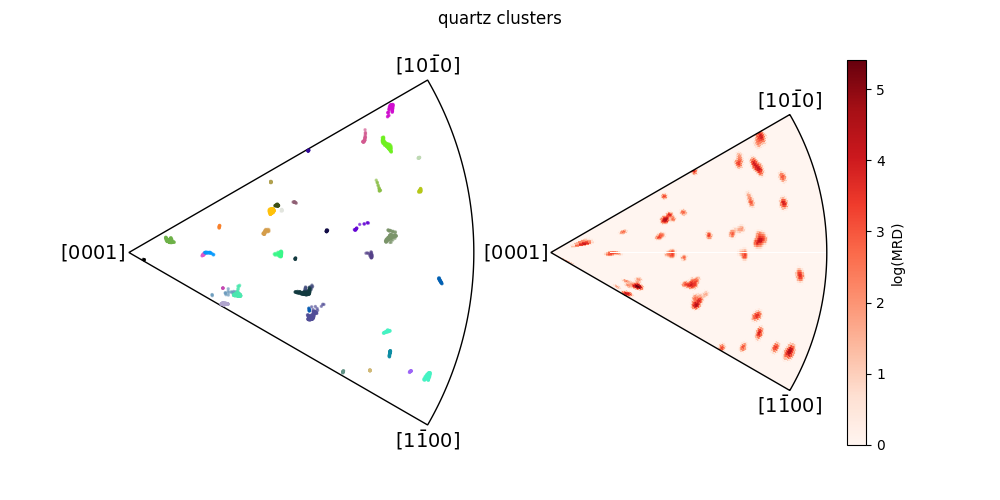

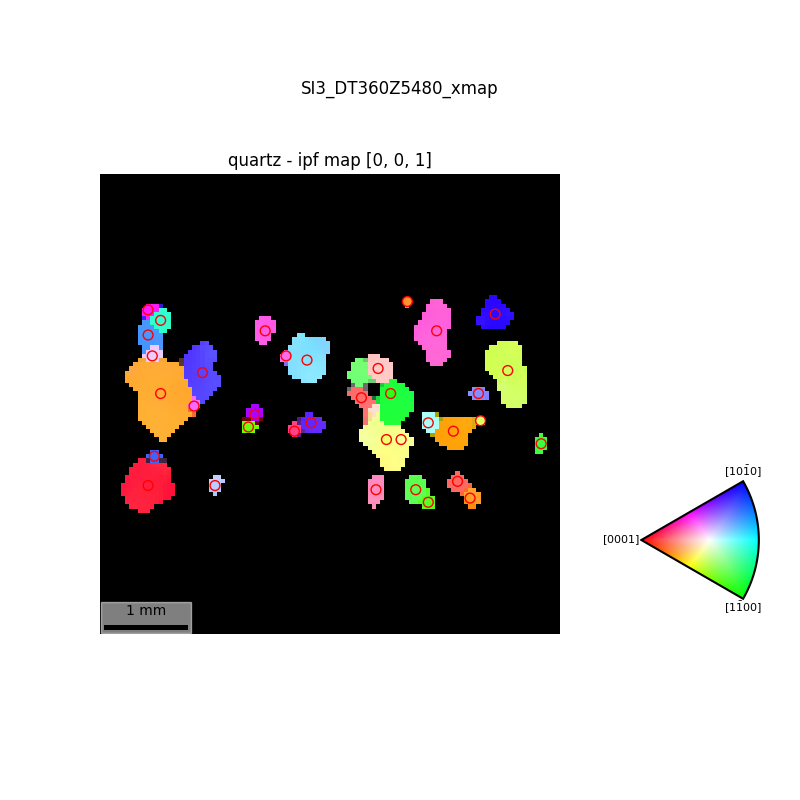

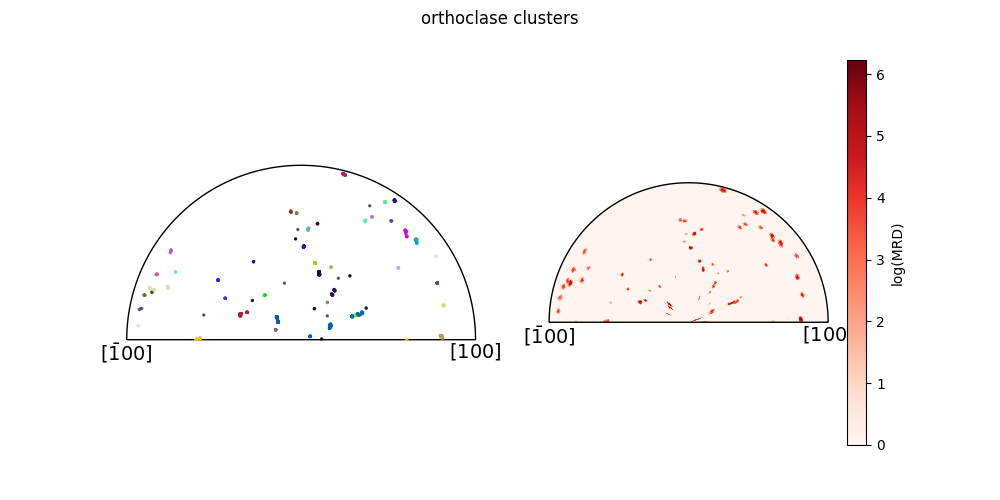

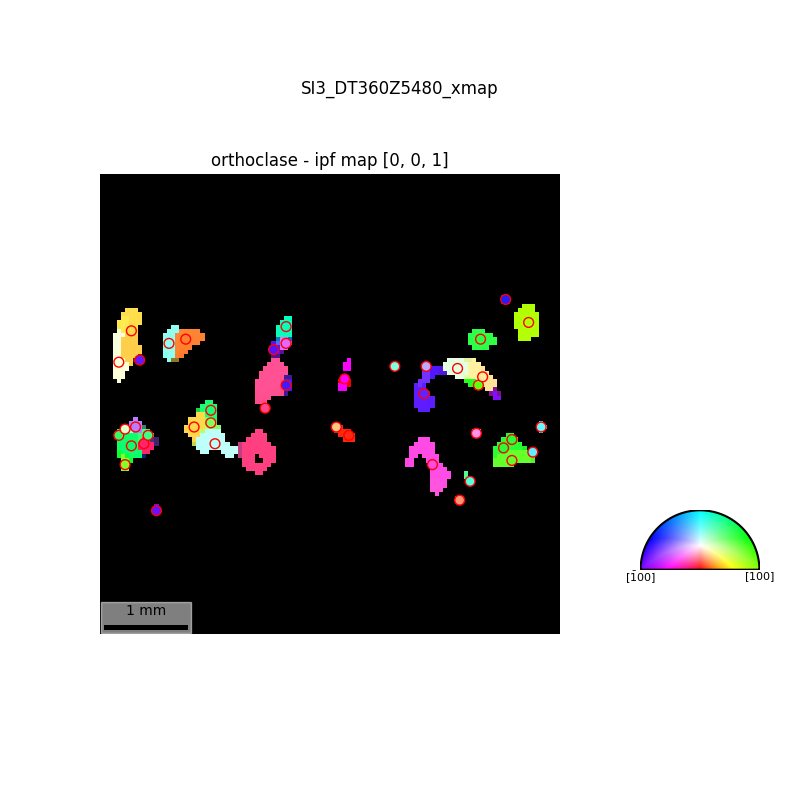

In [93]:
# plots in inverse pole figure space
for pname in phase_name_list:
    clst_ori, clst_rgb, cs = make_ipf_plots(pname, ipf_direction=[0,0,1], save=False)

### Add grain labels to xmaps
extract labels stored in grain_labels dict and update grain_id columns in all 2D pixelmaps in DATA_dict

In [94]:
def add_grain_labels_to_xmaps(pname):
    
    labels_all = grain_labels[pname]    # all labels in 3D stack     
    
    # index positions to split grain_labels[pname] by 2D slices
    inds = [0]
    for f in DATA_dict[f'features_{pname}']:
        inds.append(inds[-1] + len(f) )
    
    # loop through 2D map stack
    print(f'Adding labels to xmaps for phase {pname}')
    for i, (xmap, msk) in tqdm( enumerate(zip(DATA_dict['xmap'], DATA_dict[f'mask_{pname}'])) ):
        # extract labels corresponding to the 2D slice
        labels_slice2D = labels_all[inds[i]:inds[i+1]]
        assert len(labels_slice2D) == np.count_nonzero(msk), 'labels shape does not match with phase mask' # sanity check
        
        # update grain_id labels in xmap
        xmap.update_pixels(xmap.xyi[msk], 'grain_id', labels_slice2D)
        

In [95]:
for pname in phase_name_list:
    add_grain_labels_to_xmaps(pname)

Adding labels to xmaps for phase quartz


2it [00:00, 7489.83it/s]


Adding labels to xmaps for phase orthoclase


2it [00:00, 2360.33it/s]


Plot grain_id in each xmap to check grain maps are ok

In [ ]:
# check grain labels have been added in xmap.grain_id

In [101]:
for xmap in DATA_dict['xmap']:
    print(np.unique(xmap.grain_id))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78]


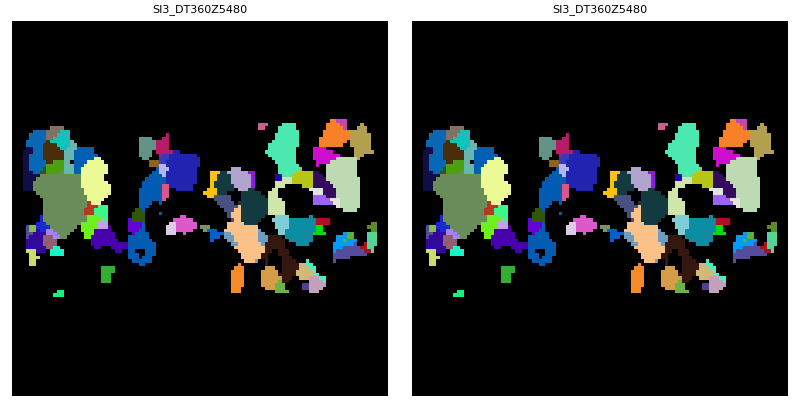

In [97]:
# plot grain_id for each map. Each grain is assigned a random color based on grain_id value
cmap = utils.random_color_map(ncolors=len(labels_unique))

kw = {'cmap':cmap, 'vmin':0, 'vmax':labels_unique.max()}
ncol = 2
nrow = np.ceil(len(DATA_dict['xmap'])/ncol).astype(int)

# grid
xmap = DATA_dict['xmap'][0]
nx, ny = xmap.grid.nx, xmap.grid.ny
xb, yb = xmap.grid.xbins, xmap.grid.ybins


pl.close('all')
fig, ax = pl.subplots(nrow, ncol, figsize=(4*ncol,4*nrow), layout = 'constrained')
ax = ax.ravel()
for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

for a,x,d in zip(ax, DATA_dict['xmap'], DATA_dict['dset']):
    #m = xmap.phase_id == xmap.phases.orthoclase.phase_id
    m = xmap.phase_id != -1
    gid = np.where(m, xmap.grain_id,-1)
    a.pcolormesh(xb,yb,gid.reshape(nx,ny), **kw)
    a.set_title(d, fontsize=8)
    

#fig.savefig(os.path.join(data_dir, dset, f'{sample}_grain_map.png'), format='png')

In [ ]:
print(xmap)

If we print xmap, we see that it still has no grain assigned in xmap.grains. They can be added from the grain_id column,  using the add_grain_from_mask method. This function selects subsets of pixels based on grain_id value and computes a "mean" unit cell matrix for each subset, which is then exported as an ImageD11.grain object and added to xmap.grains. 

In [107]:
for x,d in (zip(DATA_dict['xmap'], DATA_dict['dset'])):
    # loop through all phases
    for i, p in enumerate(phase_name_list):
        if i == 0:
            x.add_grains_from_map(p, overwrite=True)
        else:
            x.add_grains_from_map(p, overwrite=False)
            
        print(xmap)

100%|██████████| 37/37 [00:01<00:00, 32.55it/s]


Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 79


100%|██████████| 44/44 [00:01<00:00, 36.05it/s]


Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 79


100%|██████████| 37/37 [00:01<00:00, 32.43it/s]


Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 36


100%|██████████| 44/44 [00:01<00:00, 36.16it/s]

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 79


Now we see that the number of grains matches with the labels in np.unique(xmap.grain_id). xmap.grains contains a dictionnary of grains, with keys corresponding to the grain id. 

In [111]:
xmap.grains.dict

{0: <ImageD11.grain.grain at 0x7fbf4ce34550>,
 1: <ImageD11.grain.grain at 0x7fbf4ce34910>,
 2: <ImageD11.grain.grain at 0x7fbf4ce345e0>,
 3: <ImageD11.grain.grain at 0x7fbf4ce34730>,
 4: <ImageD11.grain.grain at 0x7fbf4ce34640>,
 5: <ImageD11.grain.grain at 0x7fbf4d00a250>,
 6: <ImageD11.grain.grain at 0x7fbf4d0aaeb0>,
 7: <ImageD11.grain.grain at 0x7fbf4ce343a0>,
 8: <ImageD11.grain.grain at 0x7fbf4d0aa760>,
 9: <ImageD11.grain.grain at 0x7fbf4ce342e0>,
 10: <ImageD11.grain.grain at 0x7fbf4ce34a00>,
 11: <ImageD11.grain.grain at 0x7fbf4ce348e0>,
 12: <ImageD11.grain.grain at 0x7fbf4ce34970>,
 13: <ImageD11.grain.grain at 0x7fbf4ce34d60>,
 14: <ImageD11.grain.grain at 0x7fbf4ce34be0>,
 15: <ImageD11.grain.grain at 0x7fbf4ce34280>,
 16: <ImageD11.grain.grain at 0x7fbf4ce349d0>,
 17: <ImageD11.grain.grain at 0x7fbf4ce34220>,
 18: <ImageD11.grain.grain at 0x7fbf4d0ed970>,
 19: <ImageD11.grain.grain at 0x7fbf4ce349a0>,
 20: <ImageD11.grain.grain at 0x7fbf4ce34700>,
 21: <ImageD11.grain.gr

Now we can save the pixelmaps. The grains dict will also be saved as a separate group in the h5 file. 

In [112]:
# add grains to xmap.grains and save maps
for xmap in DATA_dict['xmap']:    
    xmap.save_to_hdf5()

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5
Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


### Map peaks to grains and refine grain orientations and unit cell matrix
The grain maps obtained just above are not completely satisfactory. The unit cell matrix of each grain is obtained by taking the average of orientation and unit cell over each grain mask, to compute a "mean" unit cell matrix UBI_mean. However, this approach may not be very robust and does not take into account the variable indexing quality and number of peaks indexed of each pixel in the grain mask. 

To refine grain orientations, we need to go back to the peakfiles, and map peaks to each grain. First we need to load the peakfiles for each dataset.

In [120]:
# add peakfiles to Data dict
DATA_dict['cf'] = []
    
for dsname in dslist:
    cf = load_cf(dsname,p)
    DATA_dict['cf'].append(cf)

Reading your columnfile in hdf format
Reading your columnfile in hdf format


Now we can use the function map_pks_to_grains to map each peak in the peakfile to a grain in xmap.grains. This function updates the grain_id column in the peakfile and adds a property pksindx to each grain, which corresponds to the index position of peaks assigned to this grain in the peakfile.

In [122]:
# map grains to peakfiles
for xmap, cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    for i, p in enumerate(phase_name_list): 
        if i == 0:
            xmap.map_pks_to_grains(p, cf, overwrite=True)
        else:
            xmap.map_pks_to_grains(p, cf, overwrite=False)

peaks to grains mapping...


100%|██████████| 36/36 [00:00<00:00, 1391.84it/s]


completed
peaks to grains mapping...


100%|██████████| 43/43 [00:00<00:00, 1594.86it/s]


completed
peaks to grains mapping...


100%|██████████| 36/36 [00:00<00:00, 1453.17it/s]


completed
peaks to grains mapping...


100%|██████████| 43/43 [00:00<00:00, 1619.77it/s]

completed


We can check grain index in peakfiles and xmaps, to make sure they all match

In [124]:
def check_grain_labels(cf, xmap):
    # check grain labels are consistent in xmap.grain_id, xmap.grains and peakfile
    gids_xmap = np.unique(xmap.grain_id)
    gids_glist = np.array(xmap.grains.gids)
    gids_cf = np.unique(cf.grain_id)
    
    assert np.all(np.equal(gids_xmap[1:], gids_glist)), 'grain labels in xmap.grain_id and xmap.grains do not match'
    assert np.all(np.equal(gids_xmap, gids_cf)), 'grain labels in xmap and peakfile do not match'
    
    print('grain labels OK')
    
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    check_grain_labels(cf, xmap)

grain labels OK
grain labels OK


Now we can refine the unit cell matrices using the full set of peaks assigned to each grain. The function refine_ubis takes a hkltol parameter to remove dodgy peaks and a nmedian parameter to remove outliers.  peaks to grain labeling (g.pksindx) updated at the same time. 

pkprop corresponds to the proportion of peaks retained (from the initial peak set) for each grain after refinment and ang_dev is the rotation angle (in degree) between the older and the refined grain orientation.  

In [125]:
def refine_ubis(xmap, cf, pname, hkltol, nmedian, plot_stats=True):
    """
    for each grain, refine ubi using all peaks from cf that have been assigned to this grain
    pname : phase name
    hkltol : hkl tolerance (passed to cImage11.score_and_refine)
    nmedian:  threshold to remove outliers ( abs(median err) > nmedian )
    
    """
    cs = xmap.phases.get(pname)
    pkprop, ang_dev = xmap.refine_ubis( pname, cf, hkltol, nmedian=10, sym = cs.orix_phase.point_group.laue)
    
    if plot_stats:   
        gids = xmap.grains.get_all('gid', pname)
        gs = xmap.grains.get_all('grainsize', pname)
        
        fig = pl.figure(figsize=(5,5))
        fig.add_subplot(111)
        
        pl.scatter(pkprop, ang_dev, c = gids, s = 50 * (gs/max(gs)))
        pl.title(f'refinement stats {pname}')
        pl.xlabel('prop pks retained')
        pl.ylabel('orientation shift (deg)')
    
    return pkprop, ang_dev

refining ubis...


100%|██████████| 36/36 [00:00<00:00, 144.04it/s]


refining ubis...


100%|██████████| 43/43 [00:00<00:00, 275.63it/s]


refining ubis...


100%|██████████| 36/36 [00:00<00:00, 142.55it/s]


refining ubis...


100%|██████████| 43/43 [00:00<00:00, 274.28it/s]


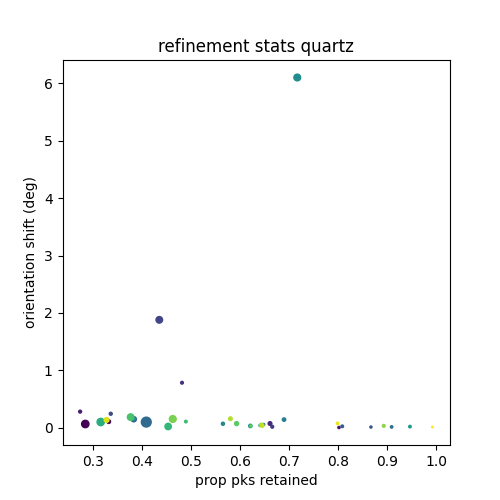

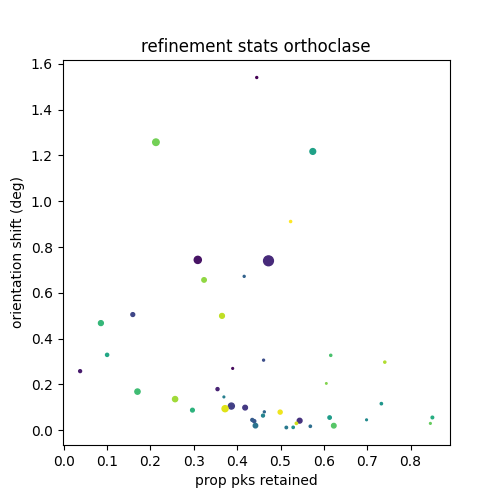

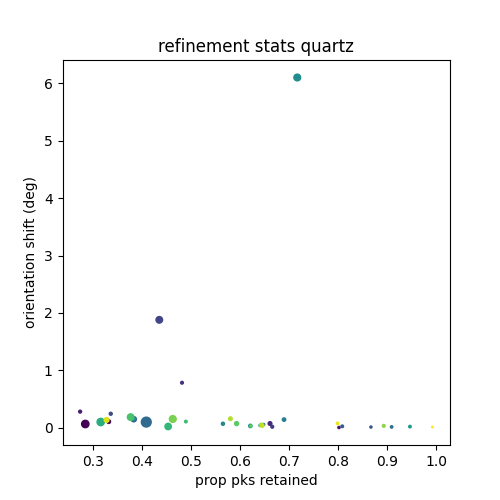

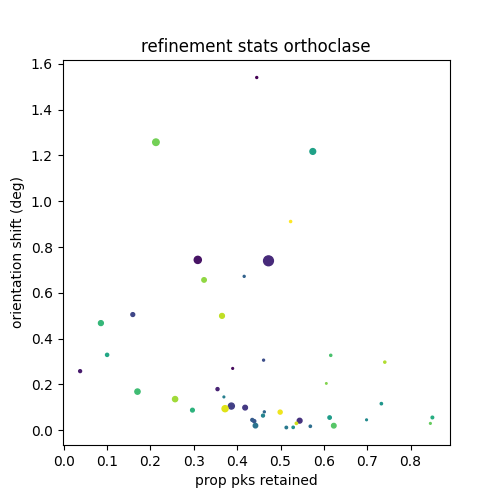

In [127]:
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    for pname in phase_name_list:
        pkprop, ang_dev = refine_ubis(xmap, cf, pname, hkltol=0.05, nmedian=10, plot_stats=True)

Don't forget to save xmap and peakfiles once refinement has been done.

In [132]:
# Once grain ubis have been refined, save files
for xmap,cf in zip(DATA_dict['xmap'], DATA_dict['cf']):
    pkspath = xmap.h5name.replace('xmap', 'pks_p_flt')
    xmap.save_to_hdf5()
    utils.colf_to_hdf(cf, pkspath, save_mode='minimal')

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5
Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


***
### Map and plot grain properties

Grain mapping has been completed. Below are a few examples of plots that can be done using grain properties.

First we can select one map and filter it to keep only one phase (e.g. quartz)

In [151]:
# select one xmap
xmap = DATA_dict['xmap'][0]

# filter to keep only quartz grains
xmap2 = xmap.filter_by_phase('quartz')
print(xmap2)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz'],
 phase_ids: [-1, 0],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 36


#### plot grain centrodis ove grain_id map

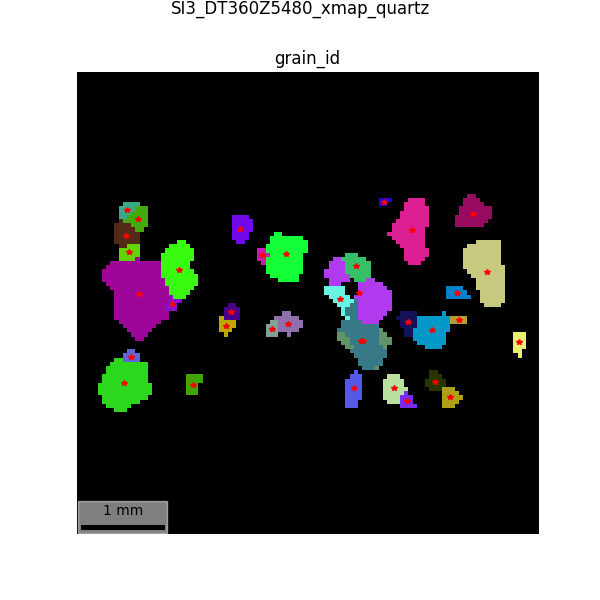

In [154]:
# color map
Ncolors = len(xmap2.grains.glist)
cmap = utils.random_color_map(ncolors=Ncolors)

kw = {'cmap':cmap, 'vmin':-2, 'vmax':Ncolors}

# select grain centroids
cen = xmap2.grains.get_all('centroid', 'quartz')

# plot grain_id and add centroids
fig = xmap2.plot('grain_id', autoscale=False, **kw, out=True, hide_cbar=True)
fig.axes[0].plot(cen[:,0], cen[:,1],'r*', ms=4.)


#### scatter plot of a grain property
Several properties have been computed for each grain , including centroid position and grain size (in px). 
We can use this to make a scatter plot of some grain property. Let's try with grain orientation spread (GOS), ie the average of the misorientation angles to the grain mean orientation.

/home/esrf/jean1994b/pf_3dxrd/pixelmap.py:217: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=(6,6))


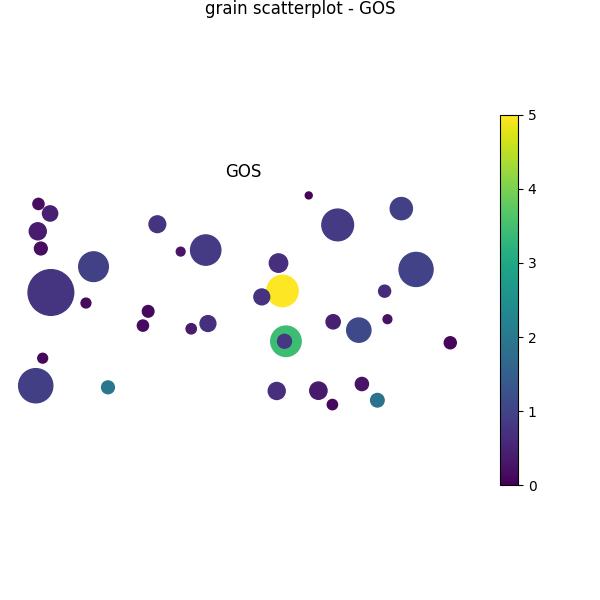

In [163]:
kw = {'vmin':0, 'vmax':5}
fig = xmap2.grains.plot_grains_prop('GOS', s_factor=1/5, **kw)
#fig.savefig(fname.replace('grainmap','grainmap_sc'), format='png', dpi=150)


#### export average grain properties to data column and plot them

Average grain properties defined in xmap.grains can be exported to a data colulmn in xmap. A suffix _g is added to make the distinction with properties defined on a per-pixel basis. The property can then be plotted as a normal property using xmap.plot

36it [00:00, 21326.97it/s]


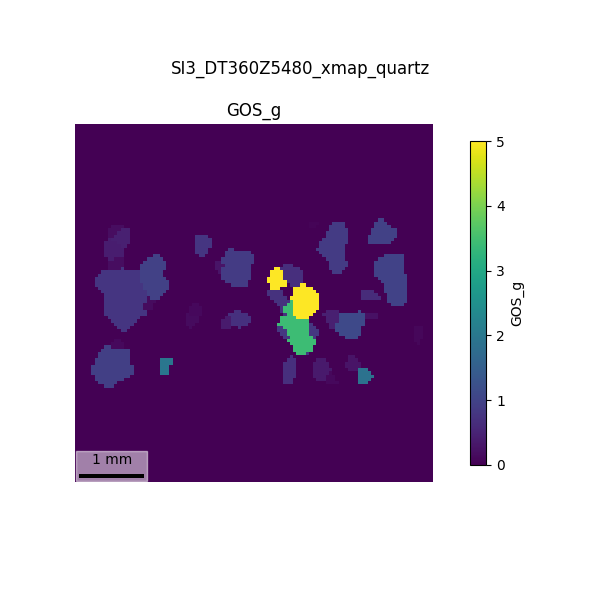

In [167]:
xmap2.map_grain_prop('GOS', pname='quartz')
xmap2.plot('GOS_g', **kw)

If we try to map mean grain orientation ('U'), the misorientation (ie, devation from mean grain orientation) will be computed for each pixel. We then obtain a misorientation map

In [168]:
# map grain orientation to xmap
xmap2.map_grain_prop('U', pname='quartz')

# reset value for notindexed pixels
notindexed = xmap2.phase_id != xmap2.phases.quartz.phase_id
xmap2.misorientation[notindexed] = -1

36it [00:00, 1064.37it/s]


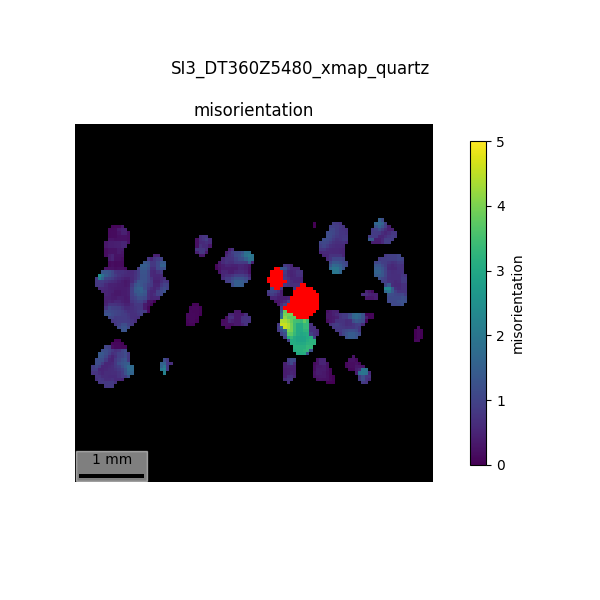

In [169]:
cmap_o = pl.matplotlib.cm.viridis.copy()
cmap_o.set_extremes(under='k', over='r')

kw = {'cmap':cmap_o, 'vmin':0,'vmax':5}
xmap2.plot('misorientation', autoscale=False, smooth=True, mf_size=3, save=False, **kw)

Here we colored large misorientation >5° in red. Suspiciously large misorientation may result from bad grain mapping, if the clusters defined by grain orientation were chose too large. In this case, different grains relatively close in orientation may be grouped in the same cluster,  resulting in large misorientation and GOS for this grain. 